In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_base_dir = '../../../datasets/Movielens/'
data_dir2 = data_base_dir + 'Movielens Latest/ml-latest/'
data_dir = data_base_dir + 'serendipity-sac2018/'

output_dir = data_dir + 'output4/'

answers = data_dir + 'answers.csv'
recommendations = data_dir + 'recommendations.csv'

# genome_scores = data_dir + 'tag_genome.csv'
# genome_scores = data_dir + 'ml20mgenome-scores.csv'
genome_scores = data_dir + 'mlLatestgenome-scores.csv'

genome_tags = data_dir + 'genome-tags.csv'
movies = data_dir + 'movies.csv'
training = data_dir + 'training.csv'
tags = data_dir + 'tags.csv'

movies_df = pd.read_csv(movies)

answers_df = pd.read_csv(answers)
ratings_df = pd.read_csv(training)

# read all users and filter ratings df
recommendations_df = pd.read_csv(recommendations)
recommendations_df

all_user_ids = recommendations_df['userId'].unique().tolist()

count_df = answers_df.groupby('userId').count()
count_df[count_df['movieId'] == 5]
all_user_ids.extend(count_df[count_df['movieId'] == 5].index.values.tolist())
all_user_ids = np.unique(np.array(all_user_ids))

all_movie_ids = ratings_df['movieId'].unique()

cut_recommendations = recommendations_df[recommendations_df['movieId'].isin(all_movie_ids)]
count_df = cut_recommendations.groupby('userId').count()
# count_df.describe()
all_user_ids = count_df[count_df['movieId'] == 8].index.values

genome_scores_df = pd.read_csv(genome_scores).pivot(index='movieId', columns='tagId', values='relevance')

tag_genome_movies = genome_scores_df.index.values
tag_genome_movies.size

# filter ratings for movies watched only by these users
ratings_df = ratings_df[ratings_df['userId'].isin(all_user_ids)]

# filter ratings for movies only having tag-genome scores
ratings_df = ratings_df[ratings_df['movieId'].isin(tag_genome_movies)]

class ContentBased_Recommender:
    def __init__(self, term_vector_df, ratings_df, K=5, metric='cosine', weighted=True):
        self.term_vector_df = term_vector_df
        self.K = K
        self.ratings_df = ratings_df
        self.weighted = weighted

        # preprocessing and other calculations
        term_vector_df.fillna(0, inplace=True)
        self.movie_movie_distances = pd.DataFrame(
            pairwise_distances(term_vector_df, metric='cosine'),
            index=term_vector_df.index,
            columns=term_vector_df.index)

    def get_predicted_rating(self, user_id, candidate_movie_id, user_movies, K):
        # hide candidate movie from the user
        user_movies = np.setdiff1d(user_movies, candidate_movie_id)

        # load user rating for watched movies other than the candidate movie
        # user_ratings =
        users_all_ratings_df = ratings_df[ratings_df['userId'] == user_id]
        users_all_ratings_df = users_all_ratings_df[
            users_all_ratings_df['movieId'].isin(user_movies)]

        # load similarities to the candidate movie
        users_all_ratings_df['sim_candidate_movie'] = self.movie_movie_distances.loc[
            candidate_movie_id, users_all_ratings_df['movieId']].values

        predicted = self.predict_rating(user_id, candidate_movie_id, users_all_ratings_df, K)

        return predicted

    def predict_rating(self, user_id, candidate_movie_id,
                       users_all_ratings_df,
                       K):
        user_ratings = users_all_ratings_df['rating'].values[:K]
        similarities = users_all_ratings_df['sim_candidate_movie'].values[:K]

        predicted_rating = 0
        if self.weighted:
            # weighted average
            predicted_rating = np.sum(user_ratings * similarities) / np.sum(similarities)
        else:
            # non-weighted average
            predicted_rating = np.sum(user_ratings) / len(user_ratings)

        return predicted_rating


class SerendipityCalculator:

    def __init__(this, ratings_df, movie_terms_df, user_genome_terms_df, primitive_recommender,
                 round_decimals,
                 unexpected_ratio, K=8):
        this.ratings_df = ratings_df
        this.movie_terms_df = movie_terms_df
        this.user_genome_terms_df = user_genome_terms_df
        this.primitive_recommender = primitive_recommender
        this.round_decimals = round_decimals
        this.unexpected_ratio = unexpected_ratio
        this.RL_SIZE = K

    def calculate_unexpectedness(this, user_id, recommendation_list, round_decimals=6,
                                 users_movies=None,
                                 unexpected_ratio=0.001):
        # get term vec for all movies watched by the user
        if users_movies is None:
            users_movies = this.ratings_df[this.ratings_df['userId'] == user_id]['movieId'].values

        user_term_vec = this.movie_terms_df.loc[users_movies, :].fillna(0).values

        # load genome tags for recommended movies
        recommendations_term_vec = this.movie_terms_df.loc[recommendation_list, :].fillna(0).values

        # calculate distances of all recommended movies with all movies watched by user
        distance_from_user_profile = pd.DataFrame(
            pairwise_distances(user_term_vec, recommendations_term_vec, metric='cosine'))

        # get minimum distance from users profile for each recommended movie
        min_distances = distance_from_user_profile.min().values

        # round distances to N decimals - parameter round_decimals
        unexpectedness = np.around(min_distances, decimals=round_decimals)

        unexpected_movies = recommendation_list[unexpectedness >= unexpected_ratio]

        return unexpected_movies

    def calculate_usefulness(this, user_id, recommendation_list, primitive_recommender=None,
                             like_threshold=3,
                             K=50):
        if primitive_recommender is None:
            primitive_recommender = this.primitive_recommender

        users_movies = this.ratings_df[this.ratings_df['userId'] == user_id]['movieId'].values

        predicted_ratings_list = list()

        # get predicted rating for each movie using the primitive recommender
        for candidate_movie_id in recommendation_list:
            predicted_rating = primitive_recommender.get_predicted_rating(user_id,
                                                                          candidate_movie_id,
                                                                          users_movies, K=K)
            predicted_ratings_list.append(predicted_rating)

        predicted_ratings_list = np.array(predicted_ratings_list)

        # filter as useful if potential rating is above or equal to the like threshold
        useful_movies = recommendation_list[predicted_ratings_list >= like_threshold]

        return useful_movies

    def calculate_serendipity(this, user_id, recommendation_list):
        unexpected_movies = this.calculate_unexpectedness(user_id, recommendation_list)
        useful_movies = this.calculate_usefulness(user_id, recommendation_list)

        serendipity = len(np.intersect1d(unexpected_movies, useful_movies)) / \
                      len(recommendation_list)

        return serendipity

    def calculate_diversity(this, user_id, recommendation_list):
        # movie_genomes_df = movie_genome_scores_df.loc[recommendation_list, :]
        movie_genomes_df = this.movie_terms_df.loc[recommendation_list, :]
        user_vector_df = this.user_genome_terms_df.loc[user_id, :].values.reshape(1, -1)
        # user_vector_df = this.

        model_pairwise_scores_df = pd.DataFrame(index=recommendation_list)
        movie_genomes_df.fillna(0, inplace=True)
        user_vector_df.fillna(0, inplace=True)
        model_pairwise_scores_df['similarity'] = pairwise_distances(user_vector_df,
                                                                    movie_genomes_df.values,
                                                                    metric='cosine').reshape(-1, 1)
        model_pairwise_scores_df['diversity'] = 1 - model_pairwise_scores_df['similarity']

        all_movies = model_pairwise_scores_df.index.values
        movie_genomes_df = this.movie_terms_df.loc[all_movies, :]

        # calculating diversity of a list (1-SIM_ij)
        intra_list_distances_df = pd.DataFrame(
            1 - pairwise_distances(movie_genomes_df.values, movie_genomes_df.values,
                                   metric='cosine'), index=all_movies,
            columns=all_movies)
        diversity_of_list = intra_list_distances_df.sum(axis=1).sum() * (
                1 / (this.RL_SIZE * (this.RL_SIZE - 1)))
        similarity_of_list = 1 - diversity_of_list

        # this is the similarity to user profile
        average_user_similarity = model_pairwise_scores_df['similarity'].mean()

        # diversity from the user profile
        average_user_diversity = model_pairwise_scores_df['diversity'].mean()

        return diversity_of_list, similarity_of_list, average_user_similarity, average_user_diversity

In [2]:
all_movie_ids = ratings_df['movieId'].unique()

cut_recommendations = recommendations_df[recommendations_df['movieId'].isin(all_movie_ids)]
count_df = cut_recommendations.groupby('userId').count()
# count_df.describe()
count_df[count_df['movieId'] == 8].index.values

# al

array([100200, 100521, 100972, 100998, 101049, 101170, 101263, 101318,
       101721, 101743, 101799, 101818, 101889, 102206, 102226, 102355,
       102665, 103266, 103561, 103573, 103636, 104273, 105111, 105148,
       105520, 106038, 106850, 106872, 106993, 107522, 107695, 107868,
       108013, 108188, 108211, 108271, 108419, 108516, 108657, 108838,
       108987, 109086, 109135, 109289, 109335, 109384, 109441, 109655,
       109763, 110038, 110039, 110077, 110246, 110296, 110343, 110386,
       110525, 110601, 110988, 111399, 111527, 111714, 111737, 111751,
       111869, 112139, 112394, 112406, 112600, 112947, 112971, 113031,
       113138, 113394, 113591, 113673, 113679, 113769, 113922, 114412,
       114454, 114756, 114855, 114934, 114952, 115003, 115169, 115551,
       115930, 116072, 116123, 116352, 116453, 116680, 117071, 117112,
       117154, 117439, 117986, 118007, 118032, 118062, 118144, 118322,
       118350, 118409, 118415, 118509, 118524, 118726, 118774, 118829,
      

In [3]:
recommendations_df

,userId,movieId
0,205229,914
1,205229,899
2,205229,160289
3,205229,69524
4,205229,147384
5,205229,1035
6,205229,7099
7,205229,6350
8,117112,32
9,117112,593


In [5]:
# ratings_df[ratings_df['movieId'] == 1608]
# ratings_df[ratings_df['movieId'] == 117112]
ratings_df[ratings_df['userId'] == 117112]

,userId,movieId,rating,timestamp
1394165,117112,68205,3.5,1491900123000
1394226,117112,71135,3.5,1491899882000
1394227,117112,90249,3.0,1491899865000
1394236,117112,87520,3.0,1491899819000
1394249,117112,57368,3.5,1491899756000
1394250,117112,68319,4.0,1491899750000
1394261,117112,68237,4.0,1491899708000
3611268,117112,93363,3.0,1458400677000
3611269,117112,2959,4.5,1458400673000
3611270,117112,356,4.5,1458400661000


In [6]:
recommendations_dir = '../../generated_data/final_recommendations/'
baseline = recommendations_dir + 'Baseline Recommendations/'
CB_recommendations_dir =  recommendations_dir + 'CB_Recommendations_Rcu05_Su10_div80_ci05/'
thresholded_dir = CB_recommendations_dir + 'thresholded'

K_Neighbours = 8
model = 'main_model_'
label = '_simMov_serendipity2018_relevantThreshold_'
finish_label = '_K' + str(K_Neighbours) + '.csv'

relevant_movies_thresholds = [0, 0.2, 0.4, 0.6, 0.8, 1]
# relevant_movies_thresholds = [0, 0.2]

cb_recommendations_file_names = list()

models = ['main_full_mov0', 'main_full_mov0.2', 'main_full_mov0.4', 'main_full_mov0.6', 'main_full_mov1']

types_under_test = ['full', 'lemmatized']
types_under_test = ['full']

for vec_type in types_under_test:
    for relevant_m_th in relevant_movies_thresholds:
        file_name = model + vec_type + label + str(relevant_m_th) + finish_label
        cb_recommendations_file_names.append(file_name)

cb_recommendations_file_names

['main_model_full_simMov_serendipity2018_relevantThreshold_0_K8.csv',
 'main_model_full_simMov_serendipity2018_relevantThreshold_0.2_K8.csv',
 'main_model_full_simMov_serendipity2018_relevantThreshold_0.4_K8.csv',
 'main_model_full_simMov_serendipity2018_relevantThreshold_0.6_K8.csv',
 'main_model_full_simMov_serendipity2018_relevantThreshold_0.8_K8.csv',
 'main_model_full_simMov_serendipity2018_relevantThreshold_1_K8.csv']

In [7]:
# load all recommendations
cb_recommendations_dfs = list()

for recommendation_file in cb_recommendations_file_names:
    cb_recommendations_dfs.append(\
        pd.read_csv(CB_recommendations_dir + recommendation_file, index_col=0)\
    )

In [13]:
from sklearn.metrics import pairwise_distances

unexpected_threshold = 0.1

# this, ratings_df, movie_terms_df, user_genome_terms_df, primitive_recommender,
#                  round_decimals,
#                  unexpected_ratio, K=8

# choose and initialize primitive recommender
primitive_recommender = ContentBased_Recommender(term_vector_df=genome_scores_df,
                                                ratings_df=ratings_df, K=50, metric='cosine',
                                                weighted=True)

# serendipity_calculators_list = list()

serendipity_calculator = SerendipityCalculator(ratings_df, movie_terms_df=genome_scores_df,
                          primitive_recommender=primitive_recommender, round_decimals=6,
                          unexpected_ratio=unexpected_threshold)

In [17]:
from time import time

serendipity_calculations_df = pd.DataFrame()

# exclude_users = [101579, 100269, 117112, 118774, 143001, 143310, 143385, 144406]

start_time = time()
for user_id in all_user_ids[:10]:
    if user_id not in exclude_users:
        print('user in test', user_id)
        series = pd.Series()
        series.name = user_id

        # serendipity for ser-2018 dataset
        recommendation_list = recommendations_df[recommendations_df['userId'] == user_id]['movieId'].values

        serendipity = serendipity_calculator.calculate_serendipity(user_id, recommendation_list)
        series['serendipity-sac2018'] = serendipity

        # serendipity for all main models
        for i, model in enumerate(models):
            rec_df = cb_recommendations_dfs[i]
            recommendation_list = rec_df.loc[user_id].values

            serendipity = serendipity_calculator.calculate_serendipity(user_id, recommendation_list)
            series[model] = serendipity

        # serendipity for all thresholded main models

        # serendipity for all baseline models (optional)

        serendipity_calculations_df = serendipity_calculations_df.append(series)

finish_time = time() - start_time

print('total time taken %f seconds' % finish_time)
    
serendipity_calculations_df
    

user in test 100200
user in test 100521
user in test 100972
user in test 100998
user in test 101049
user in test 101170
user in test 101263
user in test 101318
total time taken 6.470431 seconds


,main_full_mov0,main_full_mov0.2,main_full_mov0.4,main_full_mov0.6,main_full_mov1,serendipity-sac2018
100200,0.375,0.375,0.375,0.375,0.125,1.000
100521,0.000,0.000,0.000,0.000,0.000,0.000
100972,0.000,0.000,0.000,0.000,0.000,0.000
100998,0.000,0.000,0.000,0.000,0.000,0.000
101049,0.875,0.875,0.875,0.875,0.500,0.875
101170,0.000,0.000,0.000,0.000,0.000,0.000
101263,0.625,0.625,0.875,0.875,0.875,1.000
101318,0.125,0.000,0.250,0.375,0.625,0.125


In [18]:
serendipity_calculations_df

,main_full_mov0,main_full_mov0.2,main_full_mov0.4,main_full_mov0.6,main_full_mov1,serendipity-sac2018
100200,0.375,0.375,0.375,0.375,0.125,1.000
100521,0.000,0.000,0.000,0.000,0.000,0.000
100972,0.000,0.000,0.000,0.000,0.000,0.000
100998,0.000,0.000,0.000,0.000,0.000,0.000
101049,0.875,0.875,0.875,0.875,0.500,0.875
101170,0.000,0.000,0.000,0.000,0.000,0.000
101263,0.625,0.625,0.875,0.875,0.875,1.000
101318,0.125,0.000,0.250,0.375,0.625,0.125


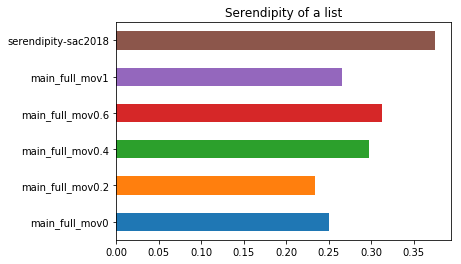

In [19]:
serendipity_calculations_df.mean().plot(title='Serendipity of a list', kind='barh')